In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from amb import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ALLCools.plot import *
age_palette = get_age_palette()
import glob
import pathlib

In [2]:
_dir = 'ABC.By.Methylation/'
_factor = 10000000
#ct = 'CA3_Glut'

In [3]:
gene_meta = pd.read_csv('/home/qzeng_salk_edu/project/240321_abc_score/use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}

In [4]:
def genome_pos(x):
    _chr, e_start, e_end, gene_id = x.split('-')
    e_start, e_end = int(e_start), int(e_end)
    #gene_start = int(gene_meta.loc[gene_id]['start'])
    #distance = abs(e_start - gene_start)
    return e_start

def prepare_df(ct,age):
    tmpdf = pd.read_csv(f'{_dir}/{ct}/{ct}.{age}.abc_score.csv', index_col = 0)
    tmpdf['normalized_count'] = (tmpdf['1']/tmpdf['1'].sum())*_factor #normalization
    tmpdf = tmpdf[tmpdf['1'] >= 10] # filter for noise
    tmpdf['gene_id'] = tmpdf.index.map(lambda x: x.split('-')[-1])
    tmpdf['gene_start'] = tmpdf['gene_id'].map(gene_meta['start'].to_dict())
    tmpdf['e_start'] = tmpdf.index.map(lambda x: genome_pos(x))
    tmpdf['eg_dist'] = abs(tmpdf['e_start'] - tmpdf['gene_start'])
    return tmpdf

def select_degs(df, deg_ct, filter_deg = True):  
    if filter_deg == True:
        ## filter for deg
        deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{deg_ct}'
        expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
        stats = np.load(f"{deg_dir}/{deg_ct}.2mo-{deg_ct}.18mo.npz") #fc:(2mo/18mo)
        
        result = pd.DataFrame({'fc': (expr[f'{deg_ct}.18mo'] /expr[f'{deg_ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
        result['log2(18mo/2mo)'] = np.log2(result['fc'])
        result['-log10(padj)'] = -np.log10(result['fdr'])
        
        sig_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.2)]
        #non_sig_result = result[(result['fdr'] >0.8) & (abs(result['log2(18mo/2mo)']) < 0.04)].sample(sig_result.shape[0])
    
        sig_gene_ids = []
        for gene_name in sig_result.index:
            try:
                gene_id = gene_name_to_id[gene_name]
            except KeyError:
                continue
            sig_gene_ids.append(gene_id)
    
        use_df = df[df['gene_id'].isin(sig_gene_ids)]
    else:
        use_df = df    
    return use_df

def select_long_genes(df, filter_long_gene = True):  
    if filter_long_gene == True:
        gene_meta['length'] = gene_meta['end'] - gene_meta['start']
        long_genes = gene_meta[gene_meta['length'] >= 100000].index
    
        ## filter for long genes
        use_df = df[df['gene_id'].isin(long_genes)]
    else:
        use_df = df
    return use_df


In [5]:
all_cts = [pathlib.Path(path).name for path in glob.glob('ABC.By.Methylation/*')]

In [6]:
filter_deg = True
filter_long_gene = False

In [7]:
def prepare_df(ct,age):
    tmpdf = pd.read_csv(f'{_dir}/{ct}/{ct}.{age}.abc_score.csv', index_col = 0)
    tmpdf = tmpdf[tmpdf['1'] >= 5] # filter for noise
    tmpdf['normalized_count'] = (tmpdf['1']/tmpdf['1'].sum())*_factor #normalization
    tmpdf['gene_id'] = tmpdf.index.map(lambda x: x.split('-')[-1])
    tmpdf['gene_start'] = tmpdf['gene_id'].map(gene_meta['start'].to_dict())
    tmpdf['e_start'] = tmpdf.index.map(lambda x: genome_pos(x))
    tmpdf['eg_dist'] = abs(tmpdf['e_start'] - tmpdf['gene_start'])
    return tmpdf

In [8]:
average_eg_dist = []
for ct in all_cts:
    if ct in(['STR_D1_Gaba','STR_D2_Gaba']):
        deg_ct = 'STR_D12_Gaba'
    else: 
        deg_ct = ct
        
    young_abc_df = prepare_df(ct, '8wk')
    old_abc_df =  prepare_df(ct, '18mo')

    use_young_abc_df = select_degs(df = young_abc_df, deg_ct = deg_ct, filter_deg = filter_deg)
    use_old_abc_df = select_degs(df = old_abc_df, deg_ct = deg_ct, filter_deg = filter_deg)

    use_young_abc_df = select_long_genes(df = use_young_abc_df, filter_long_gene = filter_long_gene)
    use_old_abc_df = select_long_genes(df = use_old_abc_df, filter_long_gene = filter_long_gene)

    shared_e_g_pairs = list(set(use_young_abc_df.index) & set(use_old_abc_df.index))
    mean_young = use_young_abc_df.loc[~use_young_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
    mean_old = use_old_abc_df.loc[~use_old_abc_df.index.isin(shared_e_g_pairs)]['eg_dist'].mean()
    
    # use_young_abc_df = use_young_abc_df.loc[shared_e_g_pairs]
    # use_old_abc_df = use_old_abc_df.loc[shared_e_g_pairs]
    average_eg_dist.append((mean_young, mean_old))

## plot unique enhancers

In [9]:
result = pd.DataFrame(average_eg_dist)
result.columns = ['Young_unique', 'Old_unique']
result.index = all_cts

In [10]:
#result['Old-Young'] = result['Old'] - result['Young']

In [11]:
normalized_result = result.div(result.mean(axis  = 1), axis='rows')

Text(0.5, 0.98, 'Enhancer-Gene Distance')

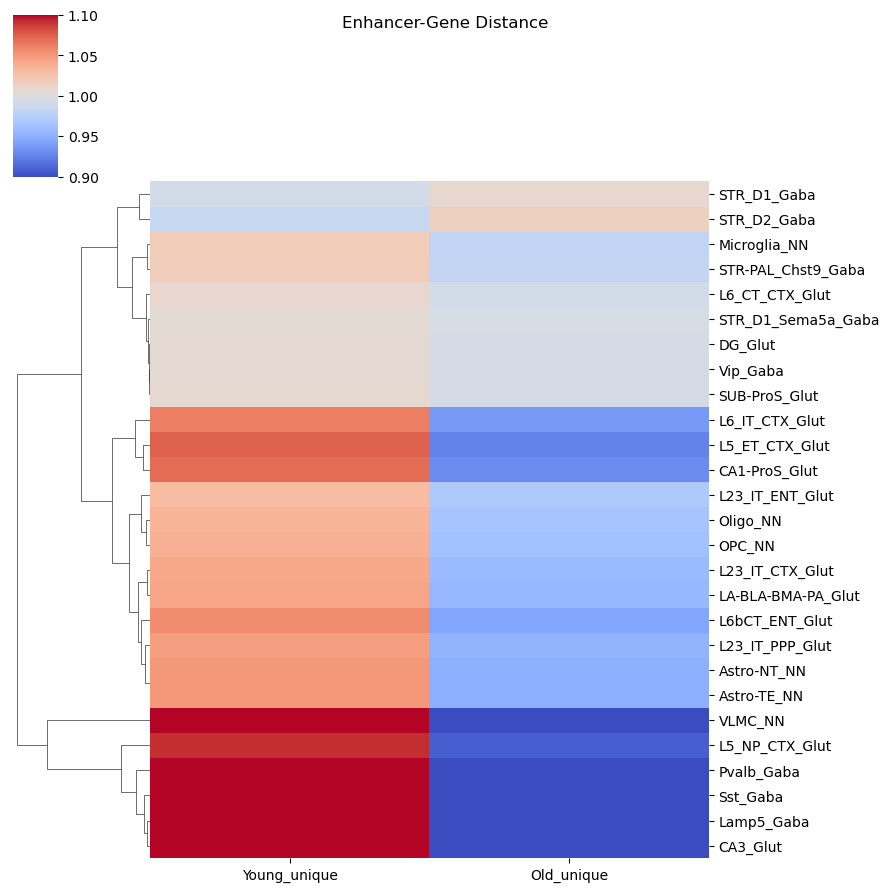

In [12]:
sns.clustermap(normalized_result,
               vmin = 0.9,vmax = 1.1,
               col_cluster=False,
               cmap = 'coolwarm',
               figsize=(9, 9))
plt.suptitle("Enhancer-Gene Distance") 
# plt.savefig('clustermap.png', dpi=300)  # save the figure with high resolution
# plt.show()  # display the plot

## plot dynamic enhancers

In [13]:
def set_cat(x):
    if x < -0.5 or x > 0.5:
        cat = 'Age Dynamic'
    else:
        cat = 'Non Age Dynamic'
    return cat

In [14]:
result = []
for ct in all_cts:
    if ct in(['STR_D1_Gaba','STR_D2_Gaba']):
        deg_ct = 'STR_D12_Gaba'
    else: 
        deg_ct = ct
        
    young_abc_df = prepare_df(ct, '8wk')
    old_abc_df =  prepare_df(ct, '18mo')

    use_young_abc_df = select_degs(df = young_abc_df, deg_ct = deg_ct, filter_deg = filter_deg)
    use_old_abc_df = select_degs(df = old_abc_df, deg_ct = deg_ct, filter_deg = filter_deg)

    use_young_abc_df = select_long_genes(df = use_young_abc_df, filter_long_gene = filter_long_gene)
    use_old_abc_df = select_long_genes(df = use_old_abc_df, filter_long_gene = filter_long_gene)

    shared_e_g_pairs = list(set(use_young_abc_df.index) & set(use_old_abc_df.index))
    
    shared_df=pd.concat([use_young_abc_df.loc[shared_e_g_pairs], use_old_abc_df.loc[shared_e_g_pairs][['0','1','2']]], axis = 1)
    shared_df.columns = ['8wk.activity', '8wk.contacts','8wk.abc','8wk.normalized_count',
                         'gene_id','gene_start','e_start','eg_dist',
                         '18mo.activity', '18mo.contacts','18mo.abc']
    all_to_plot = []
    for gene_id , tmpdf in shared_df.groupby('gene_id'):
        tmpdf['Rank_8wk'] = tmpdf['8wk.abc'].rank()
        tmpdf['Rank_18mo'] = tmpdf['18mo.abc'].rank()
        tmpdf['Importance_8wk'] = tmpdf['Rank_8wk']/tmpdf.shape[0]
        tmpdf['Importance_18mo'] = tmpdf['Rank_18mo']/tmpdf.shape[0]
        tmpdf['Importance_change'] = tmpdf['Importance_18mo'] - tmpdf['Importance_8wk'] 
        all_to_plot.append(tmpdf)
    
    all_to_plot = pd.concat(all_to_plot)
    all_to_plot['cat'] = all_to_plot['Importance_change'].apply(lambda x: set_cat(x))
    all_to_plot['contact_change'] = all_to_plot['18mo.contacts'] - all_to_plot['8wk.contacts']
    all_to_plot['activity_change'] = all_to_plot['18mo.activity'] - all_to_plot['8wk.activity']
    dynamic, non_dynamic = all_to_plot.groupby('cat')['eg_dist'].mean()['Age Dynamic'], all_to_plot.groupby('cat')['eg_dist'].mean()['Non Age Dynamic']
    result.append((dynamic, non_dynamic))
    

In [15]:
result = pd.DataFrame(result)
result.columns= ['age_dynamic', 'non_age_dynamic']

In [16]:
result.index = all_cts

In [17]:
normalized_result = result.div(result.mean(axis  = 1), axis='rows')

Text(0.5, 0.98, 'Enhancer-Gene Distance')

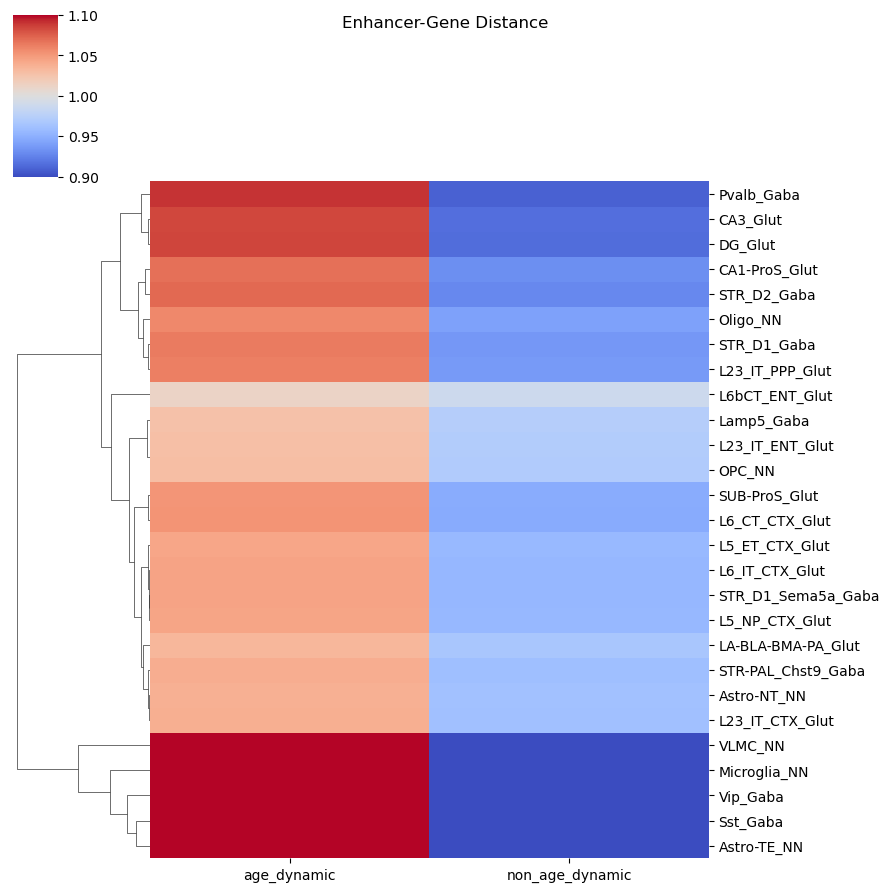

In [18]:
sns.clustermap(normalized_result,
               vmin = 0.9,vmax = 1.1,
               col_cluster=False,
               cmap = 'coolwarm',
               figsize=(9, 9))
plt.suptitle("Enhancer-Gene Distance") 